In [40]:
import os
import cv2
import yaml
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

__import__("importlib").reload(__import__("visenet"))
from visenet import ViSeNet, INPUT_SHAPE

In [39]:
def imshow(img):
    plt.axis('off')
    plt.imshow(
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    )
    plt.show()

Mess around with the data provided

In [41]:
with open("./DAVIS/Annotations/db_info.yml", "r") as f:
    info = yaml.safe_load(f)["sequences"]
frames = [i["num_frames"] for i in info if i["set"] == "test"]
print(frames)

[50, 80, 84, 90, 75, 40, 104, 90, 60, 52, 50, 90, 50, 50, 49, 40, 80, 100, 43, 99]


Preprocessing data for the model

In [42]:
TIME_RANGE = INPUT_SHAPE[0]
FOLDER_PATH = "./DAVIS/{}/480p/{}"


def video_data_generator(*, steps_per_epoch, epochs, n_repeat=1, training=True):
    
    """
    Returns a generator with both training and testing data.
    Configure steps_per_epoch and epochs the same as in model.fit()
        Dataset has 30 videos for training and 20 videos for testing.
        In that, there is an average of 69 frames each.
    To estimate number of data in total:
        (69 - TIME_RANGE) * 30 = N
        When TIME_RANGE = 16, N = 1590 
        When TIME_RANGE = 32, N = 1110
    You can also cap the number of these similar frames generated with n_repeat.
        (n_repeat) * 50 = N
        When n_repeat = 10, N = 500
    """

    # get the sets to work with
    with open("./DAVIS/Annotations/db_info.yml", "r") as f:
        metadata = yaml.safe_load(f)
    target_set = "training" if training else "test"
    names = [set["name"] for set in metadata["sequences"] if set["set"] == target_set]

    # shuffle for testing
    if not training:
        random.shuffle(names)

    assert steps_per_epoch < 30 * n_repeat or not training, "You're requesting too many values. The generator will run out."

    data_count = 0
    while (epochs := epochs - 1) >= 0:
        data_count = 0
        for folder in names:

            # exit when enough data for the epoch
            if data_count == steps_per_epoch:
                continue

            # determine the frames in the video
            frames = sorted([*map(lambda x: x.split(".")[0], os.listdir(FOLDER_PATH.format("Annotations", folder)))])
            if len(frames) < TIME_RANGE:
                continue

            # determine how many iterations we can do of the video: if max_frame is 16, we can do 0-15 and 1-16
            max_frame = int(frames[-1])
            for i, start in enumerate(range(max_frame - TIME_RANGE + 2)):

                # exit if enough data is reached or too many iterations of the video generated
                if data_count == steps_per_epoch or i == n_repeat:
                    break

                # obtain data for each frame
                real_video, mask_video = [], []
                for i, step in enumerate(frames[start : start + TIME_RANGE]):
                    # read each image and append to data
                    real = cv2.imread(FOLDER_PATH.format("JPEGImages", f"{folder}/{step}.jpg"))
                    mask = cv2.imread(FOLDER_PATH.format("Annotations", f"{folder}/{step}.png"))
                    mask_video.append(cv2.threshold(cv2.resize(mask, (128, 128)), 150, 255, cv2.THRESH_BINARY)[1] / 255)
                    real_video.append(cv2.resize(real, (128, 128)) / 255)

                # return the video data
                data_count += 1
                yield np.array([real_video]), np.array([mask_video])

# debugging purposes
for video, mask in video_data_generator(steps_per_epoch=29, epochs=50):
    break

In [49]:
model = ViSeNet(vdepth=3, learning_rate=5e-3, pretrained_weights="checkpoints/cp.ckpt")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 128, 128, 3)]    0         []                            
                                                                                                  
 sequential_28 (Sequential)  (None, 32, 128, 128, 64)     14144     ['input_3[0][0]']             
                                                                                                  
 sequential_29 (Sequential)  (None, 32, 128, 128, 64)     49280     ['sequential_28[0][0]']       
                                                                                                  
 batch_normalization_14 (Ba  (None, 32, 128, 128, 64)     256       ['sequential_29[0][0]']       
 tchNormalization)                                                                          

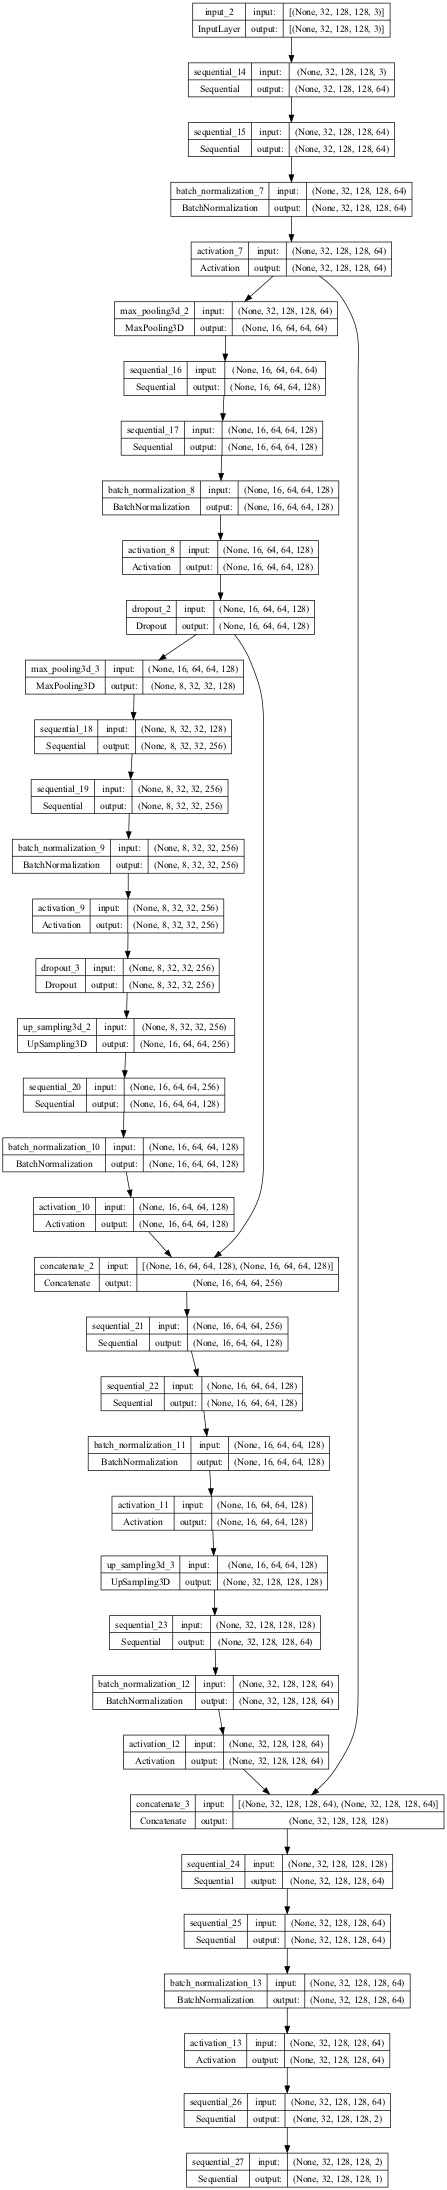

In [44]:
plot_model(model, show_shapes=True, expand_nested=False, dpi=50)

Overfit the model to test if it can work

In [ ]:
# load model with weights
checkpoint_path = "checkpoints/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# train model
epoch_config = {"steps_per_epoch": 29, "epochs": 50}
model.fit(video_data_generator(**epoch_config), **epoch_config, callbacks=[cp_callback])

Get first value of generator and exit, display result on that video

1/1 [==============================] - 2s 2s/step


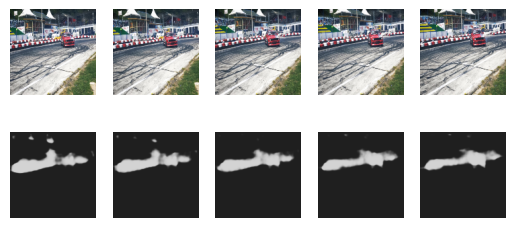

In [86]:
NUM_DISPLAYED = 5
FRAME_OFFSET = 10
for video, _ in video_data_generator(epochs=1, steps_per_epoch=25, training=False):
    
    mask = model.predict(video)

    # plot an example of the masks
    figure, axis = plt.subplots(2, NUM_DISPLAYED)
    plt.subplots_adjust(hspace=-0.5)
    for i in range(NUM_DISPLAYED):

        # transform to displayable
        example_vid = (video[0][i+FRAME_OFFSET] * 255).astype(np.uint8)
        example_mask = (mask[0][i+FRAME_OFFSET] > 0.5).astype(np.uint8) * 255
        raw_mask = (mask[0][i+FRAME_OFFSET] * 255).astype(np.uint8)

        # display side-to-side
        axis[0, i].axis('off')
        axis[0, i].imshow(cv2.cvtColor(example_vid, cv2.COLOR_BGR2RGB))
        axis[1, i].axis('off')
        axis[1, i].imshow(cv2.cvtColor(raw_mask, cv2.COLOR_BGR2RGB))

    plt.show()

    break